<a href="https://colab.research.google.com/github/dalatorrem/Diplomado_Metodos_UCentral_2023/blob/main/Lectura_41_TS_APLICA_stud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

<p align="center">
  <img src="https://raw.githubusercontent.com/lacamposm/Diplomado_Metodos_UCentral/main/data/images/imagen_ucentral.jpg" alt="logo_Ucentral" width="400px" height="300px">
</p>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

## DF

In [2]:
datos_input = pd.read_csv('https://github.com/dalatorrem/Diplomado_Metodos_UCentral_2023/raw/main/data/datos_input.csv', parse_dates=['DATE'])
datos_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    290 non-null    datetime64[ns]
 1   GDP     290 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.7 KB


In [3]:
datos_input

DATE        GDP
0   1947-01-01   2033.061
1   1947-04-01   2027.639
2   1947-07-01   2023.452
3   1947-10-01   2055.103
4   1948-01-01   2086.017
..         ...        ...
285 2018-04-01  18598.135
286 2018-07-01  18732.720
287 2018-10-01  18783.548
288 2019-01-01  18927.281
289 2019-04-01  19021.860

[290 rows x 2 columns]

In [4]:
px.line(datos_input, x='DATE', y='datos_input')

In [5]:
datos_input['DATE'].dt.year

0      1947
1      1947
2      1947
3      1947
4      1948
       ... 
285    2018
286    2018
287    2018
288    2019
289    2019
Name: DATE, Length: 290, dtype: int64

In [7]:
piv_datos_input = pd.pivot_table(datos_input, index='MONTH', columns='YEAR', values='datos_input', aggfunc='mean')
piv_datos_input

YEAR       1947      1948      1949      1950      1951      1952      1953  \
MONTH                                                                         
1      2033.061  2086.017  2105.562  2184.872  2415.660  2540.550  2697.855   
4      2027.639  2120.450  2098.380  2251.507  2457.517  2546.022  2718.709   
7      2023.452  2132.598  2120.044  2338.514  2508.166  2564.401  2703.411   
10     2055.103  2134.981  2102.251  2383.291  2513.690  2648.621  2662.482   

YEAR       1954      1955      1956  ...       2010       2011       2012  \
MONTH                                ...                                    
1      2649.755  2813.212  2903.671  ...  15415.145  15712.754  16129.418   
4      2652.643  2858.988  2927.665  ...  15557.277  15825.096  16198.807   
7      2682.601  2897.598  2925.035  ...  15671.967  15820.700  16220.667   
10     2735.091  2914.993  2973.179  ...  15750.625  16004.107  16239.138   

YEAR        2013       2014       2015       2016       2017       2018  \
MONTH                                                                     
1      16382.964  16616.540  17277.580  17556.839  17925.256  18438.254   
4      16403.180  16841.475  17405.669  17639.417  18021.048  18598.135   
7      16531.685  17047.098  17463.222  17735.074  18163.558  18732.720   
10     16663.649  17143.038  17468.902  17824.231  18322.464  18783.548   

YEAR        2019  
MONTH             
1      18927.281  
4      19021.860  
7            NaN  
10           NaN  

[4 rows x 73 columns]

In [8]:
px.imshow(piv_datos_input)

## Autocorrelación

(ACF) mide la Corelación entre una serie de tiempo y sus valores pasados
<br>
 * La caida en el ACF después de unos pocos retardos inidica dependencia finita  y el retardo en el que cae  estima del valor "q".
  
* Si la ACF muestra un patrón sinusoidal o sinusoidal amortiguado, sugiere  estacionalidad.

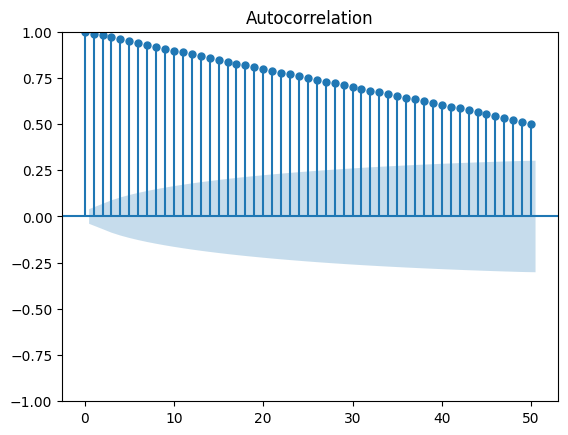

In [29]:
p = plot_acf(datos_input['datos_input'], lags=50, alpha=0.5)

**diferenciando**

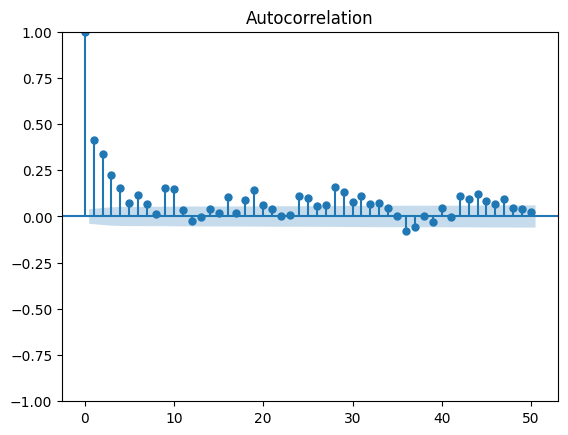

In [74]:
p = plot_acf(datos_input['datos_input'].diff().iloc[1:], lags=50, alpha=0.5)

In [27]:
acf_manual = datos_input.copy()
acf_manual['datos_input_1L'] = acf_manual['datos_input'].shift(50)
acf_manual

DATE        GDP  YEAR  MONTH     GDP_1L
0   1947-01-01   2033.061  1947      1        NaN
1   1947-04-01   2027.639  1947      4        NaN
2   1947-07-01   2023.452  1947      7        NaN
3   1947-10-01   2055.103  1947     10        NaN
4   1948-01-01   2086.017  1948      1        NaN
..         ...        ...   ...    ...        ...
285 2018-04-01  18598.135  2018      4  15066.597
286 2018-07-01  18732.720  2018      7  15267.026
287 2018-10-01  18783.548  2018     10  15302.705
288 2019-01-01  18927.281  2019      1  15326.368
289 2019-04-01  19021.860  2019      4  15456.928

[290 rows x 5 columns]

In [28]:
acf_manual[['datos_input','datos_input_1L']].corr()

GDP    GDP_1L
GDP     1.000000  0.988846
GDP_1L  0.988846  1.000000

## Autocorrelación parcial
(PACF) mide la relación entre determinado valor retrasado  y el valor actual. Se tiene en cuenta la influencia de los retardos intermedios.

* Si disminuye rápidamente después de un cierto retardo específico,  ese valor estima p.

* El corte con  la PACF proporciona una indicación del valor p.

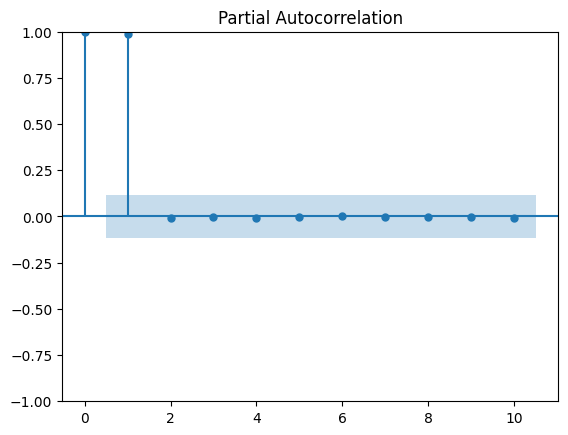

In [ ]:
pacf = plot_pacf(datos_input['datos_input'], lags=10, alpha=0.05)

## Descomposición

In [30]:
res_decompose = seasonal_decompose(datos_input[['DATE', 'datos_input']].set_index('DATE'), model='additive', extrapolate_trend='freq')

<Axes: xlabel='DATE'>

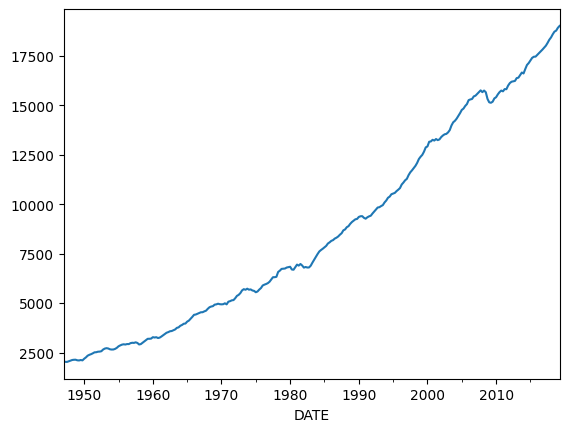

In [31]:
res_decompose.observed.plot()

<Axes: xlabel='DATE'>

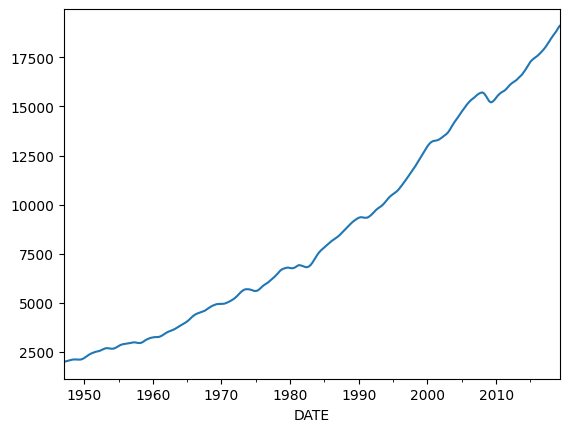

In [32]:
res_decompose.trend.plot()

<Axes: xlabel='DATE'>

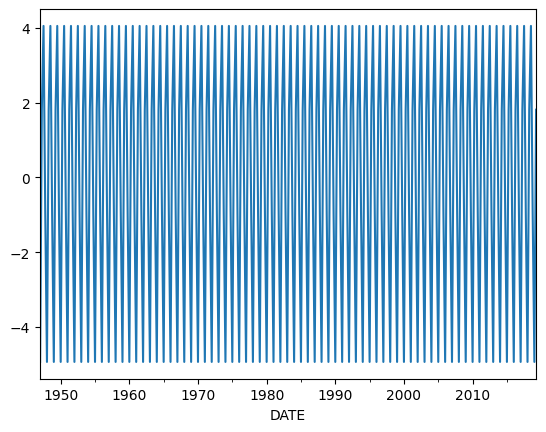

In [33]:
res_decompose.seasonal.plot()

<Axes: xlabel='DATE'>

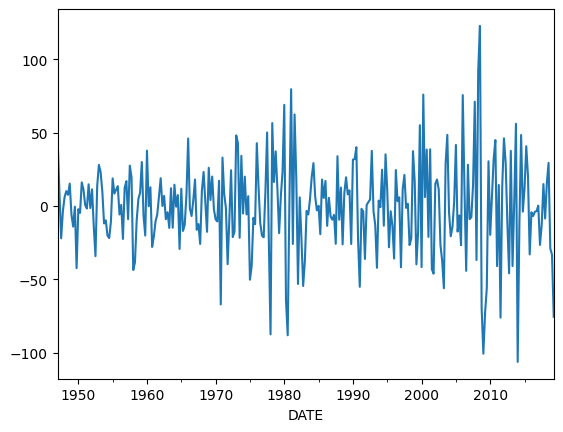

In [ ]:
res_decompose.resid.plot()

# Train - val -test

In [34]:
datos_input

DATE        GDP  YEAR  MONTH
0   1947-01-01   2033.061  1947      1
1   1947-04-01   2027.639  1947      4
2   1947-07-01   2023.452  1947      7
3   1947-10-01   2055.103  1947     10
4   1948-01-01   2086.017  1948      1
..         ...        ...   ...    ...
285 2018-04-01  18598.135  2018      4
286 2018-07-01  18732.720  2018      7
287 2018-10-01  18783.548  2018     10
288 2019-01-01  18927.281  2019      1
289 2019-04-01  19021.860  2019      4

[290 rows x 4 columns]

In [35]:
datos_train = datos_input.iloc[:-24].copy()
datos_val  = datos_input.iloc[-24:-12].copy()
datos_test  = datos_input.iloc[-12:].copy()

In [36]:
px.line(datos_train, x='DATE', y='datos_input')

In [37]:
px.line(datos_val, x='DATE', y='datos_input')

In [38]:
px.line(datos_test, x='DATE', y='datos_input')

# Modelos

### LINEAL sin Intercepto

In [85]:
modelo = SARIMAX(endog = datos_train[['DATE', 'datos_input']].set_index('DATE'), order = (1, 0, 1), seasonal_order = (1, 0, 0, 4),
                 trend=[0,1]) #'ct' = [1,1],
modelo_res = modelo.fit(disp=0)
preds_val_test = modelo_res.get_forecast(steps=pasos).predicted_mean.values
datos_val['PREDS_datos_input'] = preds_val_test[:len(datos_val)]
datos_test['PREDS_datos_input'] = preds_val_test[len(datos_val):]
print('Raíz error cuadrático medio validación:', mean_squared_error(datos_val['datos_input'], datos_val['PREDS_datos_input'])**0.5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.



Raíz error cuadrático medio validación: 172.21287907192809


In [86]:
modelo_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                GDP   No. Observations:                  266
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 4)   Log Likelihood               -1478.514
Date:                            Thu, 28 Sep 2023   AIC                           2967.028
Time:                                    00:40:43   BIC                           2984.945
Sample:                                01-01-1947   HQIC                          2974.226
                                     - 04-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.4133      0.219      1.889      0.059      -0.016       0.842
ar.L1          0.9984      0.004    245.514      0.000       0.990       1.006
ma.L1          0.2761      0.042      6.557      0.000       0.194       0.359
ar.S.L4        0.1064      0.051      2.069      0.039       0.006       0.207
sigma2      3843.4925    230.150     16.700      0.000    3392.407    4294.578
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               397.03
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               4.97   Skew:                            -1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
px.line(datos_val, x='DATE', y=['datos_input', 'PREDS_datos_input'])

In [83]:
modelo = SARIMAX(endog = datos_train[['DATE', 'datos_input']].set_index('DATE'), order = (1, 1, 1), seasonal_order = (0, 0, 0, 0),
                 trend=[0,1]) #'ct' = [1,1],
modelo_res = modelo.fit(disp=0)
modelo_res.summary()
preds_val_test = modelo_res.get_forecast(steps=pasos).predicted_mean.values
datos_val['PREDS_datos_input'] = preds_val_test[:len(datos_val)]
datos_test['PREDS_datos_input'] = preds_val_test[len(datos_val):]
print('Raíz error cuadrático medio validación:', mean_squared_error(datos_val['datos_input'], datos_val['PREDS_datos_input'])**0.5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



Raíz error cuadrático medio validación: 177.62781862585317


In [84]:
px.line(datos_val, x='DATE', y=['datos_input', 'PREDS_datos_input'])